## Name: 張宸愷
## ID: 0710018

In [1]:
# Data preprocessing

import sklearn
import numpy as np
import pandas as pd
from nltk import tokenize, ngrams, FreqDist
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# print("sdff")
bait = pd.read_json("bait.json")
non_bait = pd.read_json("not_bait.json")
data = pd.concat([bait, non_bait])
data = [[str.lower(f[0]), f[1]] for f in data.values]

question_phrase = ["what", "when", "where", "are", "is",
                   "how", "why", "can", "should", "could", "were", "was"]
feature_exclamation = ["!" in f[0] for f in data]
feature_isQuestion = []

for f in data:
    s = tokenize.word_tokenize(f[0])
    if len(s) == 0:
        feature_isQuestion.append(False)
        continue
    feature_isQuestion.append("?" in str(f[0]) or (s[0] in question_phrase))
d = []
for f in data:
    s = re.sub(r"[?!`~'\-=\+@/;:\".,_@#$%^&]+", "", f[0])
    d.append([s, f[1]])
data = d
data = pd.DataFrame([[tokenize.word_tokenize(f[0]), f[1]] for f in d])
feature_length = pd.Series([len(f[0]) for f in data.values])

# print(feature_length)

all_counts = [[], [], []]
for i in data.values:
    for size in range(3):
        all_counts[size] += (ngrams(i[0], size+1))
freq = list(range(3))
for size in range(3):
    freq[size] = FreqDist(all_counts[size])

features = pd.DataFrame()
features[0] = [(1 if f else 0) for f in feature_exclamation]
features[1] = [(1 if f else 0) for f in feature_isQuestion]
features[2] = feature_length
cv = CountVectorizer(max_features=200, ngram_range=(1, 3), tokenizer=tokenize.word_tokenize)
cv_fit = cv.fit_transform([f[0] for f in d]).toarray()
# print(cv_fit.toarray().shape)
# print(cv.get_feature_names_out())
features = pd.concat([features, pd.DataFrame(cv_fit), pd.Series([f[1] for f in data.values])],axis=1)
features = features.to_numpy()

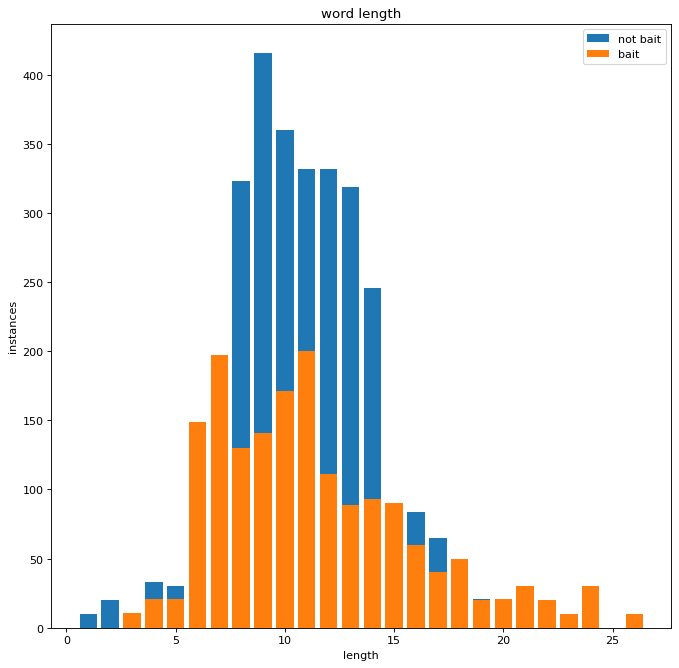

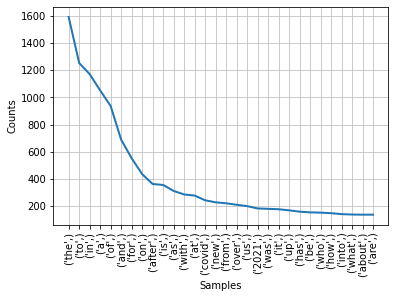

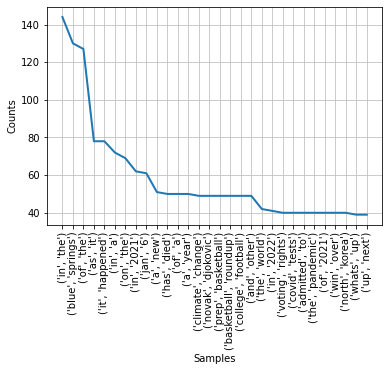

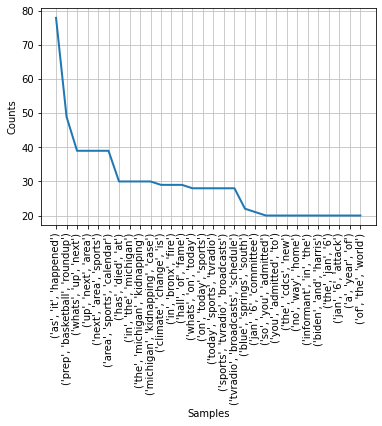

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [2]:
# Data visualization

import matplotlib.pyplot as plt

select_bait = (data[1] == 1)
select_not = (data[1] == 0)
_ = plt.figure(figsize=(10, 10), dpi=80)
bait:pd.Series = feature_length[select_bait].value_counts()
not_bait:pd.Series = feature_length[select_not].value_counts()
_ = plt.bar(not_bait.index.values, not_bait.values, label="not bait")
_ = plt.bar(bait.index.values, bait.values, label="bait")
plt.legend()
plt.title("word length")
plt.xlabel("length")
plt.ylabel("instances")

_ = plt.figure()
freq[0].plot(30)
freq[1].plot(30)
freq[2].plot(30)



In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

def r2pd(r:dict) -> pd.DataFrame:
    df = pd.DataFrame(index=['0','1'])
    acc = r['accuracy']
    df['precision'] = [r['0']['precision'], r['1']['precision']]
    df['recall'] = [r['0']['recall'], r['1']['recall']]
    df['accuracy'] = [acc, acc]
    return df

def conf2pd(ary:np) -> pd.DataFrame:
    df = pd.DataFrame(ary, index=['0 (true)', '1 (true)'], columns=['0 (pred)', '1 (pred)'])
    return df

train_X, test_X, train_y, test_y = train_test_split(features[:, 0:-1], features[:, -1:].reshape(-1), train_size=0.7)


NB = MultinomialNB(alpha=1)
NB.fit(train_X, train_y)
pred_y = NB.predict(test_X)
r = classification_report(test_y, pred_y, output_dict=True)
confm = confusion_matrix(test_y, pred_y)

print(r2pd(r).to_markdown())
print()
print(conf2pd(confm).to_markdown())
print()

rfc = RandomForestClassifier()
rfc.fit(train_X, train_y)
pred_y = rfc.predict(test_X)
r = classification_report(test_y, pred_y, output_dict=True)
confm = confusion_matrix(test_y, pred_y)


print(r2pd(r).to_markdown())
print()
print(conf2pd(confm).to_markdown())
print()

svm = SVC(kernel='linear', degree=12)
svm.fit(train_X, train_y)
pred_y = svm.predict(test_X)

r = classification_report(test_y, pred_y, output_dict=True)
confm = confusion_matrix(test_y, pred_y)

print(r2pd(r).to_markdown())
print()
print(conf2pd(confm).to_markdown())
print()



|    |   precision |   recall |   accuracy |
|---:|------------:|---------:|-----------:|
|  0 |    0.841021 | 0.917559 |   0.831095 |
|  1 |    0.805556 | 0.663202 |   0.831095 |

|          |   0 (pred) |   1 (pred) |
|:---------|-----------:|-----------:|
| 0 (true) |        857 |         77 |
| 1 (true) |        162 |        319 |

|    |   precision |   recall |   accuracy |
|---:|------------:|---------:|-----------:|
|  0 |    0.991498 | 0.998929 |    0.99364 |
|  1 |    0.99789  | 0.983368 |    0.99364 |

|          |   0 (pred) |   1 (pred) |
|:---------|-----------:|-----------:|
| 0 (true) |        933 |          1 |
| 1 (true) |          8 |        473 |

|    |   precision |   recall |   accuracy |
|---:|------------:|---------:|-----------:|
|  0 |    0.915377 | 0.949679 |   0.908834 |
|  1 |    0.894619 | 0.829522 |   0.908834 |

|          |   0 (pred) |   1 (pred) |
|:---------|-----------:|-----------:|
| 0 (true) |        887 |         47 |
| 1 (true) |         82 | 